# Document Classification

To explore the objectives of this project refer to [Read Me.](README.md)

If you are running this project for the first time, first make sure you have all the libraries with:
```
pip install -r requirements.txt
```

Then run `main.py` to collect online resources with:
```
py main.py
```

This notebook deals with classification of blog posts.

In [60]:
# To shuffle data keys
import numpy as np

# To manipulate data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For measuring performance
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# For generating visual presentations
import seaborn as sns
import matplotlib.pyplot as plt

# Classification models
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# For deep learning model
import tensorflow as tf
import keras
from keras import layers

# To access local resources
import file_manager as fm

## Preprocessing

Classification models needs to be fed a `(data-class)` duo. To create the data part of this format, we are merging tokens into one full clean string and creating a list of strings in `str_list`. For the classes we are populating `tags` list as we go along. All access to the data block is done through shuffled keys for randomization.

In [61]:
links = fm.get("_all_links")
data_block = fm.get("_data_block")
str_list = []
tags = []

keys = np.array(list(data_block.keys()))
np.random.shuffle(keys)
for k in keys:
	full_string = " ".join([token for token in data_block[k]['tokens'] if len(token) >= 2])
	str_list.append(full_string)
	tags.append(data_block[k]['tag'])

## Streamlining

The functions below are used in model training section to streamline the training and validation process, and provide readablity to code snippets.

In [62]:
def cross_validation_wrapper(data, labels, vector_type, model, test_split_ratio = 0.1):
	X_train, X_test, y_train, y_test = data_formatter(data, labels, vector_type, test_split_ratio)
	results = cross_validation(model, X_train, y_train, 10)
	showResults(results)

In [63]:
def data_formatter(data, labels, vec_type, test_size = 0.1):
	if vec_type == 'bow':
		cv = CountVectorizer()
		X = cv.fit_transform(data)
	elif vec_type == 'tfidf':
		tfidf = TfidfVectorizer()
		X = tfidf.fit_transform(data)
		
	le = LabelEncoder()
	y = le.fit_transform(labels)
	return train_test_split(X, y, test_size = test_size)

### Cross Validation

Cross-validation, sometimes called rotation estimation or out-of-sample testing, is any of various similar model validation techniques for assessing how the results of a statistical analysis will generalize to an independent data set. Cross-validation is a resampling method that uses different portions of the data to test and train a model on different iterations. It is mainly used in settings where the goal is prediction, and one wants to estimate how accurately a predictive model will perform in practice. In a prediction problem, a model is usually given a dataset of known data on which training is run (training dataset), and a dataset of unknown data (or first seen data) against which the model is tested (called the validation dataset or testing set). The goal of cross-validation is to test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias and to give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation. The advantage of this method over repeated random sub-sampling (see below) is that all observations are used for both training and validation, and each observation is used for validation exactly once. 10-fold cross-validation is commonly used, but in general k remains an unfixed parameter.

In [64]:
def cross_validation(model, _X, _y, _cv = 10):
	'''Function to perform K-Fold Cross-Validation
	  Parameters
	  ----------
	 model: Python Class, default=None
		    This is the machine learning algorithm to be used for training.
	 _X: array
		 This is the matrix of features.
	 _y: array
		 This is the target variable.
	 _cv: int
		Determines the number of folds for cross-validation.
	  Returns
	  -------
	  The function returns a dictionary containing the metrics 'accuracy', 'precision',
	  'recall', 'f1' for both training set and validation set.
	'''
	_scoring = ['accuracy', 'precision', 'recall', 'f1']
	results = cross_validate(estimator=model,
						 X=_X,
						 y=_y,
						 cv=_cv,
						 scoring=_scoring,
						 return_train_score=True)
	
	return {"Training Accuracy scores": results['train_accuracy'],
		    "Mean Training Accuracy": results['train_accuracy'].mean()*100,
		    "Training Precision scores": results['train_precision'],
		    "Mean Training Precision": results['train_precision'].mean(),
		    "Training Recall scores": results['train_recall'],
		    "Mean Training Recall": results['train_recall'].mean(),
		    "Training F1 scores": results['train_f1'],
		    "Mean Training F1 Score": results['train_f1'].mean(),
		    "Validation Accuracy scores": results['test_accuracy'],
		    "Mean Validation Accuracy": results['test_accuracy'].mean()*100,
		    "Validation Precision scores": results['test_precision'],
		    "Mean Validation Precision": results['test_precision'].mean(),
		    "Validation Recall scores": results['test_recall'],
		    "Mean Validation Recall": results['test_recall'].mean(),
		    "Validation F1 scores": results['test_f1'],
		    "Mean Validation F1 Score": results['test_f1'].mean()
		    }

### Training

Regardless of the model we want to train the model, get an accuracy rating, create a report, and generate a heatmap of confusion matrix of its performance. All of this helps us measure the performace of each model and compare them with each other. Instead of copy-pasting the same code, we have created a pipeline for it in this function.

In [65]:
def trainModel(estimator, data, tags, vector_type, test_split_ratio):
	X_train, X_test, y_train, y_test = data_formatter(data, tags, vector_type, test_split_ratio)
	estimator.fit(X_train, y_train)
	y_pred = estimator.predict(X_test)
	print(f'Accuracy = {accuracy_score(y_test, y_pred)}')
	print('Classification Report')
	print(classification_report(y_test,y_pred))
	plt.figure(figsize = (5,5))
	sns.heatmap(confusion_matrix(y_test, y_pred), annot = True)
	plt.show()

### Visualization

In [66]:
def showResults(results):
	for k in results.keys():
		print(k)
		try:
			for i in range(len(results[k])):
				print(f'{i}th Fold : ', results[k][i])
		except Exception as e:
			print(results[k])
	return

## Model Training

We have trained 5 different models with %80 of the data as training dataset and used the rest %20 for testing purposes.

These models are:
- Multinomial Naive Bayes
- Decision Tree
- Random Forest
- Support Vector Machines(SVM)
- Recurrent Neural Network(RNN)

For each model we have used non-weighted and TF-IDF weighted version of the data and will be comparing them as we go along.

---


### Multinomial Naive Bayes

The Multinomial Naive Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The algorithm guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for a given sample and outputs the tag with the greatest chance.

#### BOW

In [67]:
clf = MultinomialNB()
cross_validation_wrapper(str_list, tags, 'bow', clf)

Training Accuracy scores
0th Fold :  0.9854545454545455
1th Fold :  0.9890909090909091
2th Fold :  0.9890909090909091
3th Fold :  0.9927272727272727
4th Fold :  0.9854545454545455
5th Fold :  0.9854545454545455
6th Fold :  0.9818840579710145
7th Fold :  0.9891304347826086
8th Fold :  0.9891304347826086
9th Fold :  0.9855072463768116
Mean Training Accuracy
98.72924901185772
Training Precision scores
0th Fold :  0.983739837398374
1th Fold :  0.9918032786885246
2th Fold :  0.9838709677419355
3th Fold :  1.0
4th Fold :  0.983739837398374
5th Fold :  0.983739837398374
6th Fold :  0.9836065573770492
7th Fold :  0.991869918699187
8th Fold :  0.984
9th Fold :  0.9838709677419355
Mean Training Precision
0.9870241202443755
Training Recall scores
0th Fold :  0.983739837398374
1th Fold :  0.983739837398374
2th Fold :  0.991869918699187
3th Fold :  0.983739837398374
4th Fold :  0.983739837398374
5th Fold :  0.983739837398374
6th Fold :  0.975609756097561
7th Fold :  0.9838709677419355
8th Fold :  0

Accuracy = 0.9117647058823529
Classification Report
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        40
           1       0.84      0.96      0.90        28

    accuracy                           0.91        68
   macro avg       0.91      0.92      0.91        68
weighted avg       0.92      0.91      0.91        68



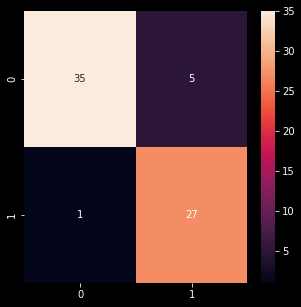

In [68]:
clf = MultinomialNB()
trainModel(clf, str_list, tags, 'bow', 0.2)

#### TF-IDF

In [69]:
clf = MultinomialNB()
cross_validation_wrapper(str_list, tags, 'tfidf', clf)

Training Accuracy scores
0th Fold :  0.9709090909090909
1th Fold :  0.9745454545454545
2th Fold :  0.9781818181818182
3th Fold :  0.9745454545454545
4th Fold :  0.9745454545454545
5th Fold :  0.9745454545454545
6th Fold :  0.9782608695652174
7th Fold :  0.9818840579710145
8th Fold :  0.9746376811594203
9th Fold :  0.9782608695652174
Mean Training Accuracy
97.60316205533594
Training Precision scores
0th Fold :  1.0
1th Fold :  0.9915254237288136
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Precision
0.9991525423728813
Training Recall scores
0th Fold :  0.9349593495934959
1th Fold :  0.9512195121951219
2th Fold :  0.9512195121951219
3th Fold :  0.943089430894309
4th Fold :  0.943089430894309
5th Fold :  0.943089430894309
6th Fold :  0.9516129032258065
7th Fold :  0.9596774193548387
8th Fold :  0.9435483870967742
9th Fold :  0.9512195121951219
Mean Training Recall
0.9472724888539208
Training F

Accuracy = 0.9264705882352942
Classification Report
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        40
           1       1.00      0.82      0.90        28

    accuracy                           0.93        68
   macro avg       0.94      0.91      0.92        68
weighted avg       0.93      0.93      0.93        68



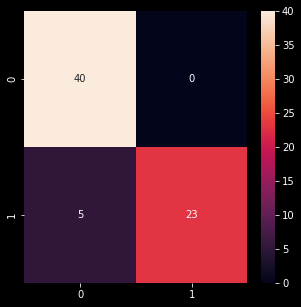

In [70]:
clf = MultinomialNB()
trainModel(clf, str_list, tags, 'tfidf', 0.2)

### Decision Tree

Decision tree classifiers provide a readable classification model that is potentially accurate in many different application contexts, including energy-based applications. The decision tree classifier creates the classification model by building a decision tree. Each node in the tree specifies a test on an attribute, each branch descending from that node corresponds to one of the possible values for that attribute. Each leaf represents class labels associated with the instance. Instances in the training set are classified by navigating them from the root of the tree down to a leaf, according to the outcome of the tests along the path.

#### BOW

In [71]:
dtc = DecisionTreeClassifier()
cross_validation_wrapper(str_list, tags, 'bow', dtc)

Training Accuracy scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Accuracy
100.0
Training Precision scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Precision
1.0
Training Recall scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Recall
1.0
Training F1 scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training F1 Score
1.0
Validation Accuracy scores
0th Fold :  0.9354838709677419
1th Fold :  0.967741935483871
2th Fold :  0.967741935483871
3th Fold :  0.8387096774193549
4th Fold 

Accuracy = 0.9411764705882353
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        33
           1       0.97      0.91      0.94        35

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



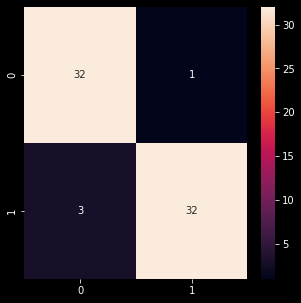

In [72]:
dtc = DecisionTreeClassifier()
trainModel(dtc,str_list, tags, 'bow', 0.2)

#### TF-IDF

In [73]:
dtc = DecisionTreeClassifier()
cross_validation_wrapper(str_list, tags, 'tfidf', dtc)


Training Accuracy scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Accuracy
100.0
Training Precision scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Precision
1.0
Training Recall scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Recall
1.0
Training F1 scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training F1 Score
1.0
Validation Accuracy scores
0th Fold :  0.9032258064516129
1th Fold :  0.9354838709677419
2th Fold :  0.9032258064516129
3th Fold :  0.8064516129032258
4th Fol

Accuracy = 0.8970588235294118
Classification Report
              precision    recall  f1-score   support

           0       0.89      0.92      0.91        37
           1       0.90      0.87      0.89        31

    accuracy                           0.90        68
   macro avg       0.90      0.89      0.90        68
weighted avg       0.90      0.90      0.90        68



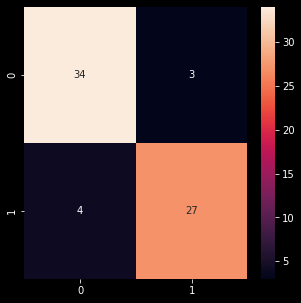

In [74]:
dtc = DecisionTreeClassifier()
trainModel(dtc,str_list, tags, 'tfidf', 0.2)

### Random Forest

Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned. Random decision forests correct for decision trees' habit of overfitting to their training set. Random forests generally outperform decision trees, but their accuracy is lower than gradient boosted trees. However, data characteristics can affect their performance.

#### BOW

In [75]:
rfc = RandomForestClassifier(15)
cross_validation_wrapper(str_list, tags, 'bow', rfc)


Training Accuracy scores
0th Fold :  0.9963636363636363
1th Fold :  1.0
2th Fold :  0.9963636363636363
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  0.9963768115942029
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  0.9963768115942029
Mean Training Accuracy
99.85480895915678
Training Precision scores
0th Fold :  0.9921875
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Precision
0.99921875
Training Recall scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  0.9921259842519685
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  0.9921259842519685
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  0.9921259842519685
Mean Training Recall
0.9976377952755906
Training F1 scores
0th Fold :  0.996078431372549
1th Fold :  1.0
2th Fold :  0.9960474308300395
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  0.9960474308300395
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  

Accuracy = 0.8088235294117647
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.74      0.80        35
           1       0.76      0.88      0.82        33

    accuracy                           0.81        68
   macro avg       0.81      0.81      0.81        68
weighted avg       0.82      0.81      0.81        68



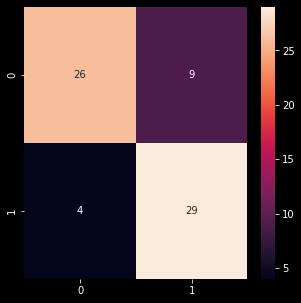

In [76]:
rfc = RandomForestClassifier(15)
trainModel(rfc,str_list, tags, 'bow', 0.2)

#### TF-IDF

In [77]:
rfc = RandomForestClassifier(15)
cross_validation_wrapper(str_list, tags, 'tfidf', rfc)


Training Accuracy scores
0th Fold :  0.9963636363636363
1th Fold :  1.0
2th Fold :  0.9963636363636363
3th Fold :  1.0
4th Fold :  0.9927272727272727
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  0.9963768115942029
8th Fold :  1.0
9th Fold :  1.0
Mean Training Accuracy
99.81831357048748
Training Precision scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  0.9923076923076923
3th Fold :  1.0
4th Fold :  0.9848484848484849
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Precision
0.9977156177156177
Training Recall scores
0th Fold :  0.9922480620155039
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  0.9923076923076923
8th Fold :  1.0
9th Fold :  1.0
Mean Training Recall
0.9984555754323197
Training F1 scores
0th Fold :  0.9961089494163424
1th Fold :  1.0
2th Fold :  0.9961389961389961
3th Fold :  1.0
4th Fold :  0.9923664122137404
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  0.996138996138

Accuracy = 0.8970588235294118
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        38
           1       0.90      0.87      0.88        30

    accuracy                           0.90        68
   macro avg       0.90      0.89      0.90        68
weighted avg       0.90      0.90      0.90        68



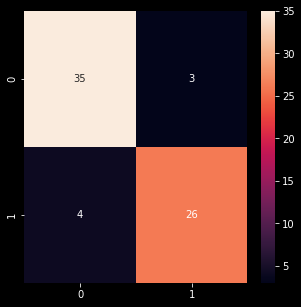

In [78]:
rfc = RandomForestClassifier(15)
trainModel(rfc,str_list, tags, 'tfidf', 0.2)

### Support Vector Machines

Support Vector Machines(SVM) are one of the most robust prediction methods, being based on statistical learning frameworks. Given a set of training examples, each marked as belonging to one of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier. SVM maps training examples to points in space so as to maximise the width of the gap between the two categories. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall. In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

#### BOW

In [79]:
svc = SVC(kernel = 'linear')
cross_validation_wrapper(str_list, tags, 'bow', svc)


Training Accuracy scores
0th Fold :  1.0
1th Fold :  0.9963636363636363
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  0.9963768115942029
8th Fold :  1.0
9th Fold :  1.0
Mean Training Accuracy
99.9274044795784
Training Precision scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Precision
1.0
Training Recall scores
0th Fold :  1.0
1th Fold :  0.9920634920634921
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  0.9920634920634921
8th Fold :  1.0
9th Fold :  1.0
Mean Training Recall
0.9984126984126984
Training F1 scores
0th Fold :  1.0
1th Fold :  0.9960159362549801
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  0.9960159362549801
8th Fold :  1.0
9th Fold :  1.0
Mean Training F1 Score
0.999203187250996
Validation Accuracy scores
0

Accuracy = 0.8676470588235294
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        42
           1       0.81      0.85      0.83        26

    accuracy                           0.87        68
   macro avg       0.86      0.86      0.86        68
weighted avg       0.87      0.87      0.87        68



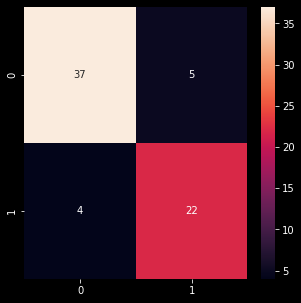

In [80]:
svc = SVC(kernel = 'linear')
trainModel(svc,str_list, tags, 'bow', 0.2)

#### TF-IDF

In [81]:
svc = SVC(kernel = 'linear')
cross_validation_wrapper(str_list, tags, 'tfidf', svc)


Training Accuracy scores
0th Fold :  1.0
1th Fold :  0.9963636363636363
2th Fold :  0.9963636363636363
3th Fold :  0.9963636363636363
4th Fold :  0.9963636363636363
5th Fold :  0.9963636363636363
6th Fold :  0.9963768115942029
7th Fold :  0.9963768115942029
8th Fold :  0.9963768115942029
9th Fold :  0.9963768115942029
Mean Training Accuracy
99.67325428194994
Training Precision scores
0th Fold :  1.0
1th Fold :  1.0
2th Fold :  1.0
3th Fold :  1.0
4th Fold :  1.0
5th Fold :  1.0
6th Fold :  1.0
7th Fold :  1.0
8th Fold :  1.0
9th Fold :  1.0
Mean Training Precision
1.0
Training Recall scores
0th Fold :  1.0
1th Fold :  0.9919354838709677
2th Fold :  0.9919354838709677
3th Fold :  0.9919354838709677
4th Fold :  0.9919354838709677
5th Fold :  0.9919354838709677
6th Fold :  0.9919354838709677
7th Fold :  0.9919354838709677
8th Fold :  0.992
9th Fold :  0.992
Mean Training Recall
0.9927548387096774
Training F1 scores
0th Fold :  1.0
1th Fold :  0.9959514170040485
2th Fold :  0.9959514170040

Accuracy = 0.8970588235294118
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91        36
           1       0.96      0.81      0.88        32

    accuracy                           0.90        68
   macro avg       0.91      0.89      0.90        68
weighted avg       0.91      0.90      0.90        68



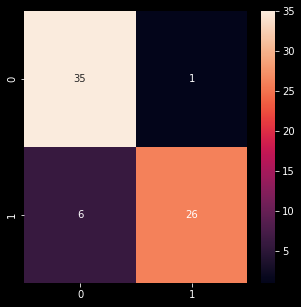

In [82]:
svc = SVC(kernel = 'linear')
trainModel(svc,str_list, tags, 'tfidf', 0.2)

### Deep Learning

#### Recurrent Neural Networks

A recurrent neural network (RNN) is a class of artificial neural networks where connections between nodes form a directed or undirected graph along a temporal sequence. This allows it to exhibit temporal dynamic behavior. Derived from feedforward neural networks, RNNs can use their internal state (memory) to process variable length sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition. Recurrent neural networks are theoretically Turing complete and can run arbitrary programs to process arbitrary sequences of inputs.

#### Data Reformatting

We will be using Keras while building our deep learning model. Keras expects TensorFlow datasets so we need to create a TF dataset from our data. We split the data 9:1 for training vs testing. 

In [83]:
binary_tags = []
for tag in tags:
	if tag == "javascript":
		binary_tags.append(0)
	else:
		binary_tags.append(1)

train_str_list = tf.data.Dataset.from_tensor_slices(str_list[: int(len(str_list) * .9)])
train_tags = tf.data.Dataset.from_tensor_slices(binary_tags[: int(len(binary_tags) * .9)])
train_dataset = tf.data.Dataset.zip((train_str_list, train_tags))

test_str_list = tf.data.Dataset.from_tensor_slices(str_list[int(len(str_list) * .9) :])
test_tags = tf.data.Dataset.from_tensor_slices(binary_tags[int(len(binary_tags) * .9) :])
test_dataset = tf.data.Dataset.zip((test_str_list, test_tags))

Then we shuffle the training dataset for randomization and create size 64 batches from it for training.

In [84]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Encoder helps us map text features to integer sequences, which are processed more easily by models.

In [85]:
VOCAB_SIZE = 1000
encoder = layers.TextVectorization(max_tokens = VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

A little sneak-peak at the first 20 words in the vocab.

In [86]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'code', 'function', 'data', 'python', 'use', 'value',
       'time', 'let', 'using', 'one', 'like', 'need', 'user', 'create',
       'javascript', 'get', 'project', 'example'], dtype='<U14')

#### Model Creation

In [87]:
model = keras.Sequential([
	encoder,
	layers.Embedding(
		input_dim = len(encoder.get_vocabulary()),
		output_dim = 32,
		# Use masking to handle the variable sequence lengths
		mask_zero = True
	),
	layers.Bidirectional(layers.LSTM(32)),
	layers.Dense(32, activation='relu'),
	layers.Dense(1)
])

model.compile(loss = keras.losses.BinaryCrossentropy(from_logits = True),
			  optimizer = keras.optimizers.adam_v2.Adam(1e-4),
			  metrics = ['accuracy'])

In [88]:
history = model.fit(train_dataset.repeat(10000),
					epochs = 12,
					steps_per_epoch = 30,
					validation_data = test_dataset.repeat(10000),
					validation_steps = 30)

Epoch 1/12
30/30 [==============================] - 19s 454ms/step - loss: 0.6916 - accuracy: 0.5327 - val_loss: 0.6901 - val_accuracy: 0.6176
Epoch 2/12
30/30 [==============================] - 14s 458ms/step - loss: 0.6894 - accuracy: 0.5327 - val_loss: 0.6882 - val_accuracy: 0.6176
Epoch 3/12
30/30 [==============================] - 13s 426ms/step - loss: 0.6866 - accuracy: 0.5327 - val_loss: 0.6855 - val_accuracy: 0.6176
Epoch 4/12
30/30 [==============================] - 11s 374ms/step - loss: 0.6823 - accuracy: 0.5327 - val_loss: 0.6818 - val_accuracy: 0.6176
Epoch 5/12
30/30 [==============================] - 12s 388ms/step - loss: 0.6749 - accuracy: 0.5327 - val_loss: 0.6759 - val_accuracy: 0.6176
Epoch 6/12
30/30 [==============================] - 11s 367ms/step - loss: 0.6601 - accuracy: 0.5327 - val_loss: 0.6625 - val_accuracy: 0.6176
Epoch 7/12
30/30 [==============================] - 11s 369ms/step - loss: 0.6123 - accuracy: 0.5327 - val_loss: 0.6325 - val_accuracy: 0.6176

In [89]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2/2 [==============================] - 0s 18ms/step - loss: 0.4726 - accuracy: 0.9118
Test Loss: 0.47256922721862793
Test Accuracy: 0.9117646813392639


## Comparison